In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
from math import *

In [24]:
def cosd(a):
    return np.cos(a*pi/180)

def sind(a):
    return np.sin(a*pi/180)

def calculate_directivity(theta, phi, F):
    dtheta = pi/len(theta[:,0])
    dphi = 2*pi/len(phi[0,:])
    DIR = 0

    for F_loop, theta_loop in zip(F.flatten(), theta.flatten()):
        DIR = DIR + F_loop**2*abs(sind(theta_loop))*dtheta*dphi
    DIR = 4*pi/DIR #max value
    D =  F**2*DIR    #directivity pattern
    # note that with low resolution, the directivity calculation is not super accurate. with 50*50 matrices hertzian dipole has D = 1.895 dB, with 3000*3000 matrix D = 1.762 dB (correct value)
    return (D, DIR)

def calculate_radiation(dipoles, phiV, thetaV, r = 100):
    '''
    Calculates the radiation properties from an array of short dipoles
    theta and phi are 2D matrices that contain the values as indicated in the name. Create with numpy.meshgrid()
    dipoles = [    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False}]
    r = distance in far field
    
    returns  D, DIR, AR (=directivity pattern, max directivity, axial ratio from -1 to 1)
    '''
    phi, theta = np.meshgrid(phiV, thetaV)
    Et = 0*theta #initialize variables, add fields linearly together
    Ep = 0*theta
    
    ## eq 12, http://iris.elf.stuba.sk/JEEEC/data/pdf/07-08_102-05.pdf
    for dipole in dipoles:
        d = np.sqrt((r*sind(theta)*cosd(phi)-dipole['location'][0])**2+(r*sind(theta)*sind(phi)-dipole['location'][1])**2+(r*cosd(theta)-dipole['location'][2])**2)
        if dipole['magnetic']:
            # $E = -\frac{ k_0 \times H }{ \omega\epsilon_0}$
            Ht = np.exp(-1j*2*pi*d)*dipole['strength']*(cosd(dipole['theta'])*sind(theta) - cosd(theta)*cosd(phi-dipole['phi'])*sind(dipole['theta']))
            Ep = Ep - Ht
            Hp = np.exp(-1j*2*pi*d)*dipole['strength']*sind(dipole['theta'])*sind(phi-dipole['phi'])
            Et = Et + Hp
        else:
            #electric dipole
            Et = Et + np.exp(-1j*2*pi*d)*dipole['strength']*(cosd(dipole['theta'])*sind(theta) - cosd(theta)*cosd(phi-dipole['phi'])*sind(dipole['theta']))
            Ep = Ep + np.exp(-1j*2*pi*d)*dipole['strength']*sind(dipole['theta'])*sind(phi-dipole['phi'])

    F = np.sqrt(abs(Et)**2+abs(Ep)**2)
    F = F/F.max()


    divisor = (Et*np.conj(Et)+Ep*np.conj(Ep))
    divisor[abs(divisor)<1e-15] = 1e-15
    #p = (Et*conj(Ep)-Ep*conj(Et))/(1j*(Et*conj(Et)+Ep*conj(Ep))) #divisor is from this row, just to avoid division by zero
    p = (Et*np.conj(Ep)-Ep*np.conj(Et))/divisor
    p[abs(p)<1e-15] = 1e-15 #avoid division by 0
    AR = sind(p)*abs((1-np.sqrt(1-abs(p)**2))/abs(p))
    AR  = AR.real #AR is always real because of conjugates above, this gets rid of 0j in every cell
    
    D, DIR = calculate_directivity(theta, phi, F)
    return (D, DIR, AR)

def plot_radiation(D, DIR, AR, phiV, thetaV):


    plt.figure()
    plt.pcolormesh(phiV, thetaV, D, cmap=plt.cm.jet)
    plt.gca().invert_yaxis() #theta=0  on top
    plt.colorbar()
    plt.title('Directivity, linear scale')

    plt.figure()
    plt.pcolormesh(phiV, thetaV, AR, vmin=-1, vmax=1, cmap=plt.cm.jet)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title('Axial Ratio, linear scale (-1 = LHCP, 0 = linear, +1 = RHCP)')

    #polar plot representation of the same thing
    theta_vector = np.concatenate((thetaV, thetaV+180)) #concatenate combines two 2D vectors 
    theta_vector = theta_vector*pi/180

    # directivity
    plt.figure()
    #concatenate combines two 2D vectors 
    #np.np.np.argmin(abs(phiV-180)) finds the index in the phiV array where phiV is closest to 180 degrees
    #[::-1] inverts the order of the array
    D_vector = np.concatenate((D[:,np.argmin(abs(phiV-0))], D[:,np.argmin(abs(phiV-180))][::-1]))
    plt.polar(theta_vector, D_vector, 'b-', label='D, $\phi=0\degree$')
    D_vector = np.concatenate((D[:,np.argmin(abs(phiV-90))], D[:,np.argmin(abs(phiV-270))][::-1]))
    plt.polar(theta_vector, D_vector, 'r-', label='D, $\phi=90\degree$')
    plt.gca().set_theta_zero_location("N")
    plt.legend()

    plt.figure()
    #AR
    AR_vector = np.concatenate((AR[:,np.argmin(abs(phiV-0))], AR[:,np.argmin(abs(phiV-180))][::-1]))
    plt.polar(theta_vector, AR_vector, 'b-', label='AR, $\phi=0\degree$')
    AR_vector = np.concatenate((AR[:,np.argmin(abs(phiV-90))], AR[:,np.argmin(abs(phiV-270))][::-1]))
    plt.polar(theta_vector, AR_vector, 'r-', label='AR, $\phi=90\degree$')
    plt.gca().set_theta_zero_location("N") #theta = 0 in top
    plt.gca().set_ylim(0,1)
    plt.legend()

directivity = 2.97 = 4.7 dB


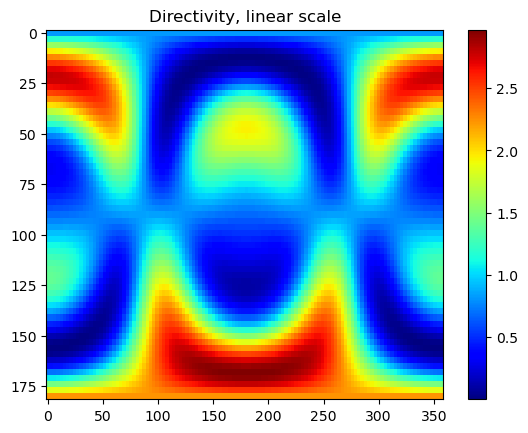

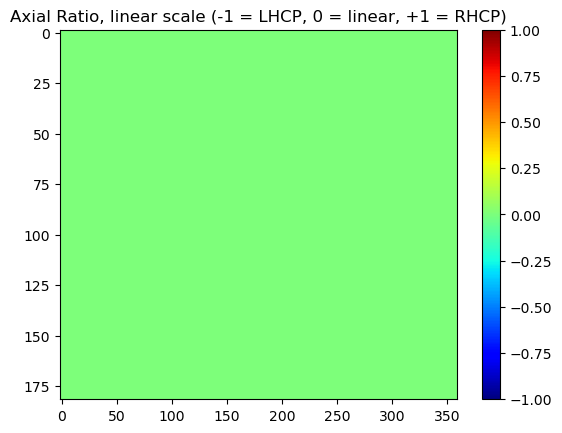

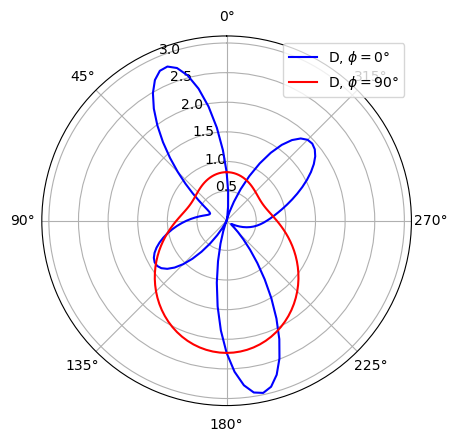

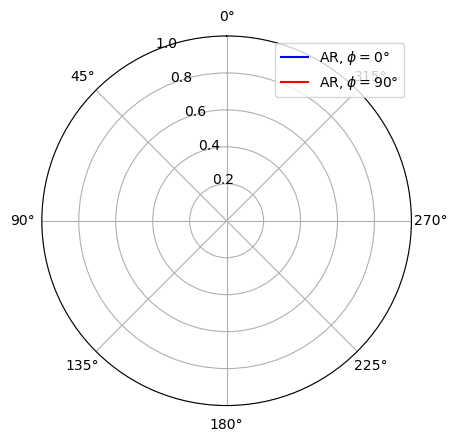

In [27]:
phiV = np.arange(0, 360, 3)
thetaV = np.arange(0, 180.01, 3) #.01 means that also 180deg is included


#choose a set of dipoles by uncommenting or writing your own

'''dipoles = [
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
]'''

'''dipoles = [ #linear "yagi"
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,-0.25], 'theta':90, 'phi':0, 'magnetic':False}
]'''

'''dipoles = [ #two crossed dipoles
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':False}
]

dipoles = [ #two crossed dipoles and a single low power reflector
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':False},
    {'strength': 0.5j, 'location':[0,0,-0.25], 'theta':90, 'phi':0, 'magnetic':False}
]



dipoles = [ #LHCP chiral antenna
    {'strength': -1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': -1j, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':True},
    {'strength': -1, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':True}
]

dipoles = [ #circular yagi
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':False},
    {'strength': 1*1j, 'location':[0,0,-0.25], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j*1j, 'location':[0,0,-0.25], 'theta':90, 'phi':90, 'magnetic':False},
    {'strength': 1*(-1j), 'location':[0,0,0.25], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j*(-1j), 'location':[0,0,0.25], 'theta':90, 'phi':90, 'magnetic':False}
]


dipoles = [
    {'strength': -1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':False},
    {'strength': 1j, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':True},
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':90, 'magnetic':True}
]
'''

dipoles = [ #two crossed dipoles and a single low power reflector
    {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False},
    {'strength': -1j, 'location':[0.8,0,0], 'theta':90, 'phi':90, 'magnetic':True},
    {'strength': 0.5j, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False}
]


D, DIR, AR = calculate_radiation(dipoles, phiV, thetaV)
print('directivity = {:.2f} = {:.2} dB'.format(DIR, 10*log10(DIR)))

plot_radiation(D, DIR, AR, phiV, thetaV)

directivity = 1.53 = 1.8 dB
directivity = 1.59 = 2.0 dB
directivity = 1.78 = 2.5 dB
directivity = 2.16 = 3.3 dB
directivity = 2.76 = 4.4 dB
directivity = 3.60 = 5.6 dB
directivity = 4.37 = 6.4 dB
directivity = 4.56 = 6.6 dB
directivity = 4.09 = 6.1 dB
directivity = 3.44 = 5.4 dB
directivity = 2.94 = 4.7 dB


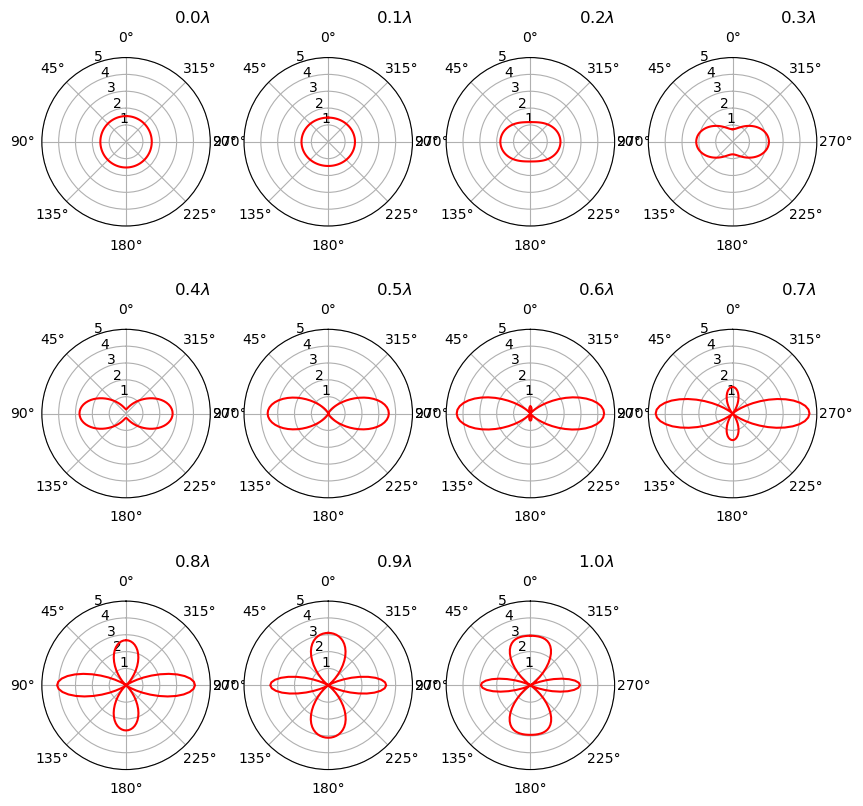

In [28]:
# An array of two horizontal electric dipole antennas that are fed with the same phase and amplitude
# the distance is varied from 0 to 1 wavelength in a loop

fig = plt.figure(figsize=(10, 10))
#polar plot representation of the same thing
theta_vector = np.concatenate((thetaV, thetaV+180)) #concatenate combines two 2D vectors 
theta_vector = theta_vector*pi/180
    


for k, dist in enumerate(np.arange(0, 1.01, 0.1)):
    dipoles = [ #two crossed dipoles and a single low power reflector
        {'strength': 1, 'location':[0,0,dist], 'theta':90, 'phi':0, 'magnetic':False},
        {'strength': 1, 'location':[0,0,0], 'theta':90, 'phi':0, 'magnetic':False}
    ]

    D, DIR, AR = calculate_radiation(dipoles, phiV, thetaV)
    print('directivity = {:.2f} = {:.2} dB'.format(DIR, 10*log10(DIR)))


    
    # directivity
    plt.subplot(3,4,k+1, polar=True)
    #concatenate combines two 2D vectors 
    #argmin(abs(phiV-180)) finds the index in the phiV array where phiV is closest to 180 degrees
    #[::-1] inverts the order of the array
    #D_vector = np.concatenate((D[:,argmin(abs(phiV-0))], D[:,argmin(abs(phiV-180))][::-1]))
    #plt.polar(theta_vector, D_vector, 'b-', label='D, $\phi=0\degree$, dist=${:.2f} \lambda$'.format(dist))
    D_vector = np.concatenate((D[:,np.argmin(abs(phiV-90))], D[:,np.argmin(abs(phiV-270))][::-1]))
    plt.polar(theta_vector, D_vector, 'r-', label='D, $\phi=90\degree$')
    plt.gca().set_theta_zero_location("N") #theta = 0 in top
    #plt.legend()
    ax=plt.gca()
    ax.set_rlim(0,5)
    plt.title('${:.1f}  \lambda$'.format(dist), loc='right')
